## Kaggle Digit Recognizer

## Importing dependencies

In [82]:
!pip install -q opendatasets

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import opendatasets as od
from tqdm.auto import tqdm
from timeit import default_timer as timer

## Downloading dataset from Kaggle

In [84]:
od.download('https://www.kaggle.com/competitions/digit-recognizer')

Skipping, found downloaded files in "./digit-recognizer" (use force=True to force download)


In [85]:
train_path = '/content/digit-recognizer/train.csv'
test_path = '/content/digit-recognizer/test.csv'
submission_path = '/content/digit-recognizer/sample_submission.csv'

## Becoming one with dataset

In [86]:
train_csv = pd.read_csv(train_path)
test_csv = pd.read_csv(test_path)
submission_csv = pd.read_csv(submission_path)


In [87]:
train_csv.head()
# we have 28*28 = 784 sized image

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
train_csv.isnull().sum().sum()
# no null data at all

0

### Label and Data split

In [89]:
labels = train_csv.label.values
train_data = train_csv.iloc[:, 1:].values
test_data = test_csv.iloc[:, :].values

In [90]:
labels[:5]

array([1, 0, 1, 4, 0])

In [91]:
train_data[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [92]:
test_data[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [93]:
train_data.min(), train_data.max()

(0, 255)

### Resizing train data into 28*28

In [94]:
train_image = train_data.reshape(train_data.shape[0], 28, 28)
test_image = test_data.reshape(test_data.shape[0], 28, 28)

### Train Val split

In [95]:
X_train, X_val, y_train, y_val = train_test_split(train_image, labels, test_size=0.2, random_state=42)

In [96]:
train_data.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape

((42000, 784), (33600, 28, 28), (8400, 28, 28), (33600,), (8400,))

### Plotting image

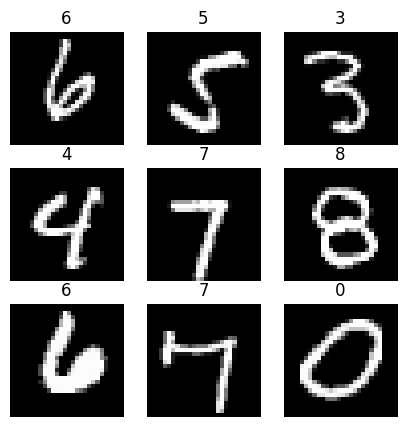

In [97]:
fig = plt.figure(figsize=(5,5))

for i in range(9):
  fig.add_subplot(3,3,i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.title(y_train[i])
  plt.axis(False)

## Preparing Dataset and Dataloader

In [98]:
# normalizing it in range of 0 to 1
X_train_tensor = torch.tensor(X_train)/255.0
y_train_tensor = torch.tensor(y_train)

X_val_tensor = torch.tensor(X_val)/255.0
y_val_tensor = torch.tensor(y_val)


test_dataset = torch.tensor(test_image)/255.0

In [99]:
X_train_tensor.min(), X_train_tensor.max()

(tensor(0.), tensor(1.))

In [100]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


Text(0.5, 1.0, '6')

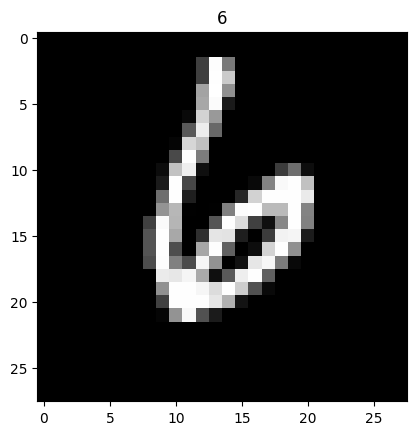

In [101]:
image, label = train_dataset[0]
plt.imshow(image.detach().cpu(), cmap='gray')
plt.title(label.item())

In [102]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

test_dataloader = DataLoader(test_dataset)

(-0.5, 27.5, 27.5, -0.5)

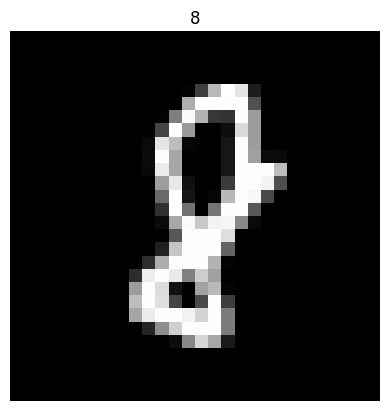

In [103]:
images, labels = next(iter(val_dataloader))
plt.imshow(images[0], cmap='gray')
plt.title(labels[0].item())
plt.axis('off')

## Training and Testing Loop

### Model Class

In [123]:
class CNNV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(hidden_units, 2*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(2*hidden_units),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.5)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(2*hidden_units, 4*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(4*hidden_units),
        nn.Conv2d(4*hidden_units, 8*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(8*hidden_units),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.5)
    )

    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(8*hidden_units*6*6, output_shape)
    )

  def forward(self, x):
    x = self.block1(x)
    # print(x.shape)
    x = self.block2(x)
    # print(x.shape)
    x = self.linear(x)
    return x

In [124]:
model = CNNV0(1, 32, 10).to(device)
model

CNNV0(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): D

### Device agnostic code

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Loss function, Optimizer and Accuracy

In [126]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

def accuracy_fn(y_pred, y_actual):
  if len(y_pred) != len(y_actual):
    raise ValueError('Inputs must be of same size')

  count = sum(p == a for p, a in zip(y_pred, y_actual))
  return count/len(y_pred)*100

### Testing ans Training loop

In [138]:
EPOCH = 40
RANDOM_STATE = 42

torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

start_time = timer()

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(EPOCH)):
  print(f'EPOCH : {epoch+1} \n----------')

  train_loss, train_acc = 0, 0
  for X_train, y_train in iter(train_dataloader):
    X_train, y_train = X_train.unsqueeze(dim=1).to(device), y_train.to(device)
    model.train()

    y_logits = model(X_train)

    loss = loss_fn(y_logits, y_train)
    train_loss += loss
    train_acc += accuracy_fn(y_logits.argmax(dim=1), y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)


  val_loss, val_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in iter(val_dataloader):
      X_val, y_val = X_val.unsqueeze(dim=1).to(device), y_val.to(device)

      val_logits = model(X_val)

      val_loss += loss_fn(val_logits, y_val)
      val_acc += accuracy_fn(val_logits.argmax(dim=1), y_val)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)


  print(f'Train Acc: {train_acc:.3f} | Train Loss: {train_loss:.5f} | Val Acc: {val_acc:.3f} | Val Loss: {val_loss:.5f}')

  train_acc_list.append(train_acc.item())
  train_loss_list.append(train_loss.item())
  val_acc_list.append(val_acc.item())
  val_loss_list.append(val_loss.item())

end_time = timer()
print(f'Time Taken: {end_time - start_time}')

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH : 1 
----------
Train Acc: 99.062 | Train Loss: 0.40043 | Val Acc: 99.251 | Val Loss: 0.42284
EPOCH : 2 
----------
Train Acc: 99.146 | Train Loss: 0.40032 | Val Acc: 99.287 | Val Loss: 0.42629
EPOCH : 3 
----------
Train Acc: 99.143 | Train Loss: 0.39027 | Val Acc: 99.370 | Val Loss: 0.43806
EPOCH : 4 
----------
Train Acc: 99.158 | Train Loss: 0.40724 | Val Acc: 99.002 | Val Loss: 0.58829
EPOCH : 5 
----------
Train Acc: 99.196 | Train Loss: 0.40680 | Val Acc: 99.287 | Val Loss: 0.41373
EPOCH : 6 
----------
Train Acc: 99.220 | Train Loss: 0.41038 | Val Acc: 99.477 | Val Loss: 0.39081
EPOCH : 7 
----------
Train Acc: 99.253 | Train Loss: 0.43524 | Val Acc: 99.323 | Val Loss: 0.42604
EPOCH : 8 
----------
Train Acc: 99.312 | Train Loss: 0.35998 | Val Acc: 99.180 | Val Loss: 0.60623
EPOCH : 9 
----------
Train Acc: 99.265 | Train Loss: 0.42204 | Val Acc: 99.216 | Val Loss: 0.62020
EPOCH : 10 
----------
Train Acc: 99.330 | Train Loss: 0.41281 | Val Acc: 99.323 | Val Loss: 0.58912

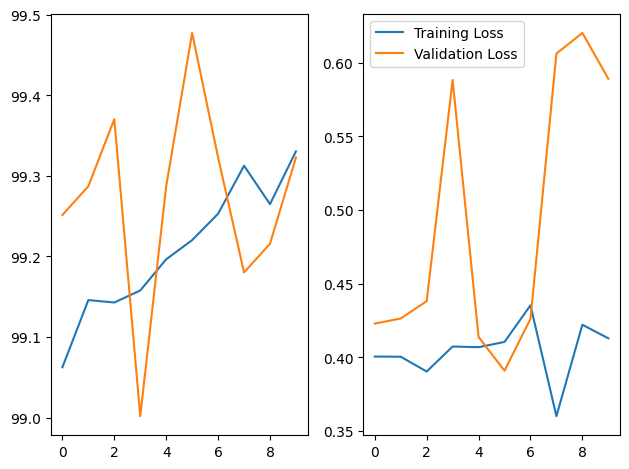

In [139]:
plt.subplot(121)
plt.plot(train_acc_list, label='Training Acc')
plt.plot(val_acc_list, label='Validation Acc')

plt.subplot(122)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')

plt.legend()
plt.tight_layout()

## Making Prediction on Test data

In [140]:
submission_csv.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [141]:
test_csv.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
test_pred = []

model.eval()
with torch.inference_mode():
  for X_test in iter(test_dataloader):
    X_test = X_test.unsqueeze(dim=1).to(device)

    val_pred = model(X_test).argmax(dim=1)
    test_pred.append(val_pred.item())

In [143]:
print(test_pred)

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 8, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 7, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 3, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 5, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 5, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

In [144]:
submission_csv['Label'] = test_pred

In [145]:
submission_csv.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [146]:
submission_csv.to_csv('submission.csv', index=False)

> first submission --> 0.99082, 404 position(out of 1784) == top 22.645%


```
class CNNV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(hidden_units, 2*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(2*hidden_units),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.5)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(2*hidden_units, 4*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(4*hidden_units),
        nn.Conv2d(4*hidden_units, 8*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(8*hidden_units),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.5)
    )
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(8*hidden_units*6*6),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(8*hidden_units*6*6, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, output_shape)
    )
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.linear(x)
    return x
```

```
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

def accuracy_fn(y_pred, y_actual):
  if len(y_pred) != len(y_actual):
    raise ValueError('Inputs must be of same size')
    
  count = sum(p == a for p, a in zip(y_pred, y_actual))
  return count/len(y_pred)*100
```

EPOCH = 40

> second submission --> 0.99125, 369 position(out of 1784) == 20.68%


```
class CNNV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(hidden_units, 2*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(2*hidden_units),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.5)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(2*hidden_units, 4*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(4*hidden_units),
        nn.Conv2d(4*hidden_units, 8*hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(8*hidden_units),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.5)
    )
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(8*hidden_units*6*6, output_shape)
    )
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.linear(x)
    return x
```

```
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

def accuracy_fn(y_pred, y_actual):
  if len(y_pred) != len(y_actual):
    raise ValueError('Inputs must be of same size')
    
  count = sum(p == a for p, a in zip(y_pred, y_actual))
  return count/len(y_pred)*100
```

EPOCH = 40